### Load, split and save train and test dataframes


In [1]:
import pandas as pd
import urllib.parse
import os
from tqdm import tqdm
import help_functions as hf
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
tqdm.pandas()

Load labels, and pre-process urls.

In [42]:
# INPUT FILES
HEURISTICS_LABELS_PATH = 'data/commonswiki-20221114-files-heuristic-labels.json.bz2'

# OUTPUT FILES
HEURISTICS_LABELS_CAN_OPEN_PATH = 'data/commonswiki-221116-files-hierarchical-labels-can-be-opened.json.bz2'
SPLIT_DATA_PATH = 'data/split_hierarchical_data_221116'

In [38]:
labels = pd.read_json(HEURISTICS_LABELS_PATH)


# ------------- Only keep files that can be opened (eliminate encoding problems)

# With this encoded url, only 190k images aren't found, while with "url" 790k aren't found
labels['url'] = labels['url'].progress_apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
print('Done changing encoding')
labels['can_be_opened'] = labels['url'].progress_apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
print(f'Total number of files: {labels.shape[0]}.')

labels = labels.loc[labels.can_be_opened == True].reset_index(drop=True)

print(f'Total number of files that can be opened: {labels.shape[0]}.')
print(labels.shape)

100%|██████████| 3891446/3891446 [00:12<00:00, 310026.88it/s]


Done changing encoding


100%|██████████| 3891446/3891446 [01:26<00:00, 45061.72it/s] 


Total number of files: 3891446.
Total number of files that can be opened: 3516309.
(3516309, 6)


In [84]:
# ------------- Only keep files in jpg format (eliminate problem of png and webp format)

labels_jpg = labels.loc[labels.url.str.endswith(('.jpg', '.JPG', '.Jpg'))]
print(f'{labels_jpg.shape[0]} images of type .jpg')

3093953 images of type .jpg


#### Extra cleaning 

When running `model.evaluate()`, it fails with the `PIL.UnidentifiedImageError` exception error. It's mostly images from format .webp, but there are also some .png images. Remove them from the dataset. Example: `!ls /scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png` works. but `PIL.Image.open('/scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png')` fails.

In [ ]:
# ------------- Extra cleaning

for index, row in tqdm(labels_jpg.iterrows(), total=labels_jpg.shape[0]):
    try:
        img = Image.open('/scratch/WIT_Dataset/images/' + row.url)
    except PIL.UnidentifiedImageError:
        print(row.url)
        labels_jpg.at[index, 'can_be_opened'] = False
    except Exception as e:
        print(e)
        labels_jpg.at[index, 'can_be_opened'] = False

openable_labels = labels_jpg.loc[labels_jpg.can_be_opened == True]

openable_labels.to_json(HEURISTICS_LABELS_CAN_OPEN_PATH)

# # Work around to avoid 11 hours runtime: use dataset whose images have already been asserted
# naive_labels = pd.read_json('data/commonswiki-20220601-files-naive-labels.json.bz2')
# openable_labels = labels.merge(naive_labels, on=['id', 'title', 'url'])
# openable_labels.drop(labels=['can_be_opened_x', 'can_be_opened_y'], axis=1, inplace=True)
# # The categories are the same, assert that, and remove one of them
# assert (openable_labels.categories_x == openable_labels.categories_y).sum() == len(openable_labels)
# openable_labels.drop(labels='categories_y', axis=1, inplace=True)
# openable_labels.rename({'categories_x': 'categories', 
#                         'labels_x': 'labels', 
#                         'labels_y': 'naive_labels'}, axis=1, inplace=True)

Split dataset and save so the same training and test sets are used throughout.

In [3]:
labels = pd.read_json(HEURISTICS_LABELS_CAN_OPEN_PATH)
print(labels.shape)
labels.head()

(3093993, 6)


,id,title,url,categories,labels,can_be_opened
0,53631642,"""Akdeniz"" - Aliağa, 2016.jpg","f/f8/""Akdeniz""_-_AliaÄa,_2016.jpg","[Akdeniz (ship, 1955), Aliağa ship-breaking yard]",[],True
1,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...","1/13/""Carnevale_di_Torino""._Felice_Cerruti_-_f...","[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[People, Art, Society, Culture]",True
2,14890941,"""Escena de playa con figura"".jpg","c/c2/""Escena_de_playa_con_figura"".jpg","[Pedro Lira, People with dogs in art]","[Society, People]",True
4,33628123,"""Keep FDA Off The Farm"" (FDA 140) (8205957369)...","b/bc/""Keep_FDA_Off_The_Farm""_(FDA_140)_(820595...","[Food and Drug Administration (United States),...","[Nature, Culture, STEM]",True
5,17073242,"""Mary Holiday"" - NARA - 559051.jpg","0/02/""Mary_Holiday""_-_NARA_-_559051.jpg","[Art of the United States, Harmon Foundation, ...","[Society, People]",True


In [9]:
# Sample images
samples = labels.sample(n=1_000_000, random_state=7)

In [14]:
train_df, test_df = train_test_split(samples, test_size=0.05, random_state=7)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=7)
val_stop_df, val_threshold_df = train_test_split(val_df, test_size=0.5, random_state=7)
print(f'Train set: {train_df.shape[0]} images ({100 * train_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Test set:  {test_df.shape[0]}  images ({100 * test_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Val early stopping set:  {val_stop_df.shape[0]}  images ({100 * val_stop_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Val threshold set:  {val_threshold_df.shape[0]}  images ({100 * val_threshold_df.shape[0] / samples.shape[0]:.2f}%)')

Train set: 760000 images (76.00%)
Test set:  50000  images (5.00%)
Val early stopping set:  95000  images (9.50%)
Val threshold set:  95000  images (9.50%)


Found 760000 non-validated image filenames belonging to 30 classes.
Found 50000 non-validated image filenames belonging to 29 classes.
Found 95000 non-validated image filenames belonging to 29 classes.
Found 95000 non-validated image filenames belonging to 29 classes.


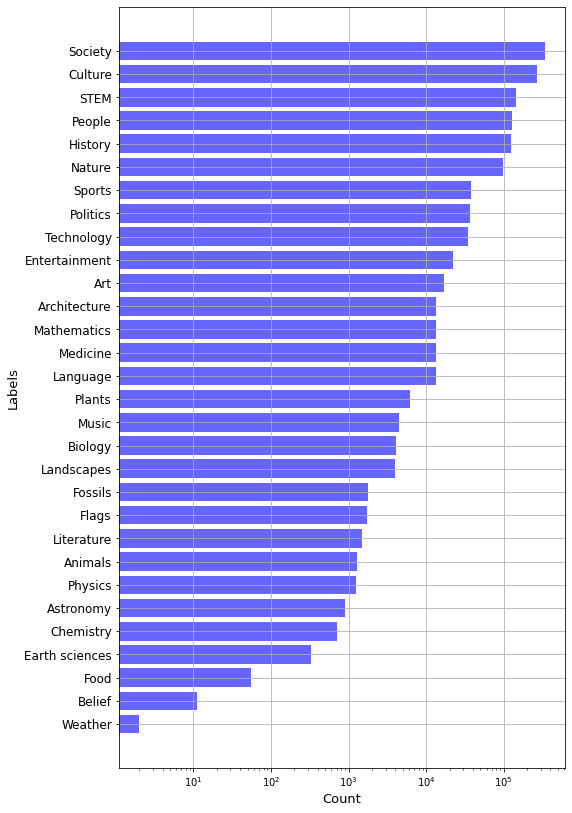

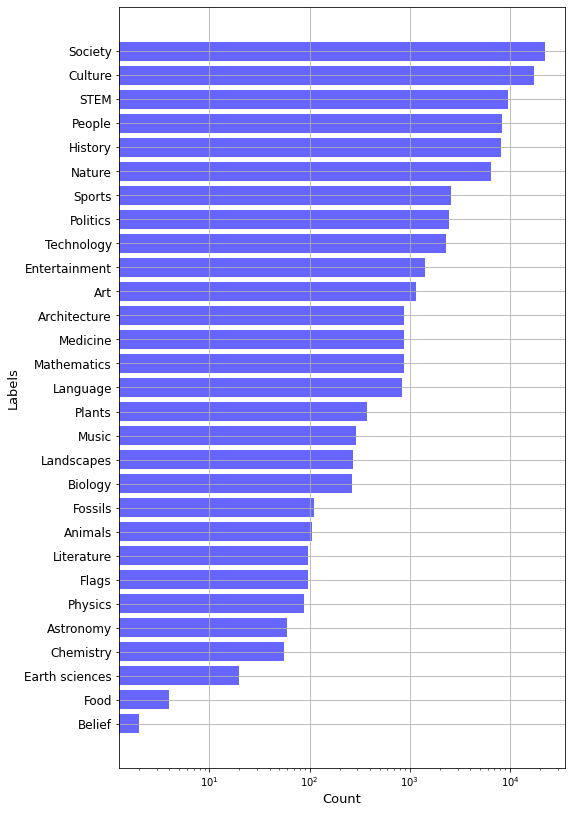

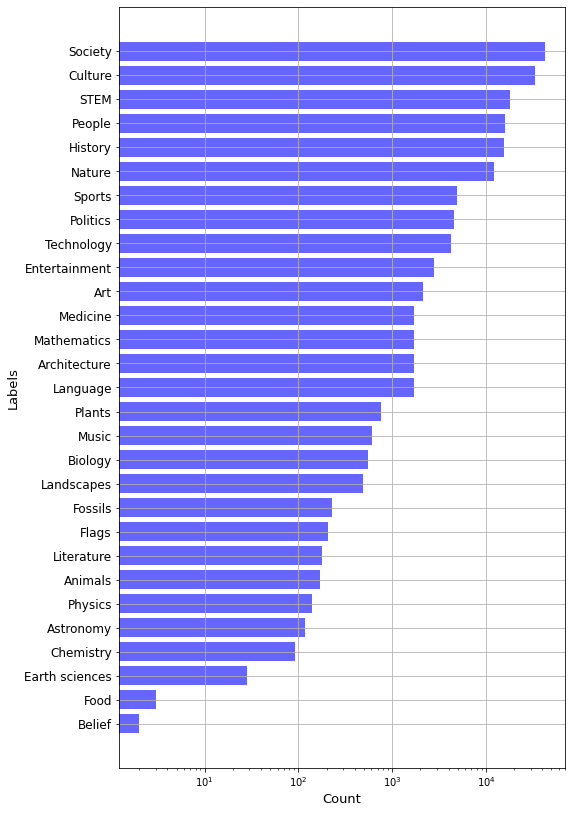

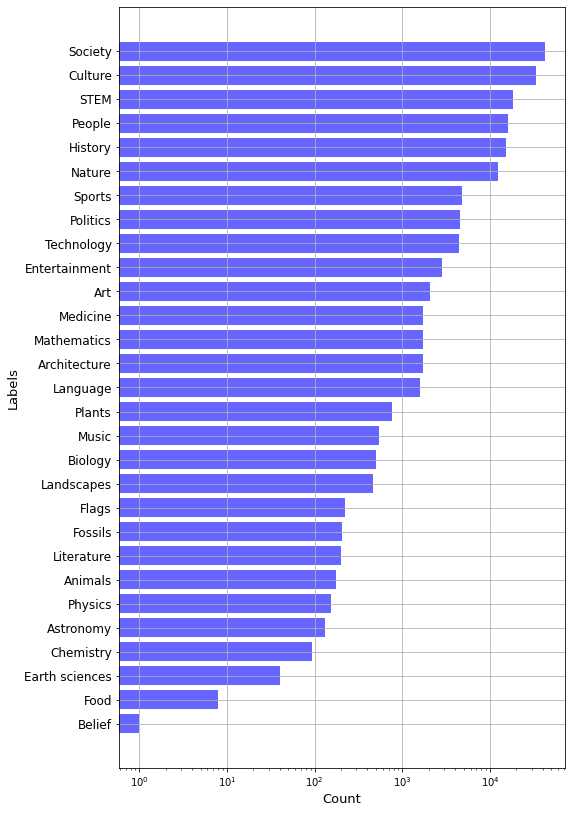

In [15]:
os.mkdir(SPLIT_DATA_PATH)
hf.plot_distribution(dataframe=train_df, filename=SPLIT_DATA_PATH + '/train_distribution.png')
hf.plot_distribution(dataframe=test_df, filename=SPLIT_DATA_PATH + '/test_distribution.png')
hf.plot_distribution(dataframe=val_stop_df, filename=SPLIT_DATA_PATH + '/val_stop_distribution.png')
hf.plot_distribution(dataframe=val_threshold_df, filename=SPLIT_DATA_PATH + '/val_threshold_distribution.png')

train_df.to_json(f'{SPLIT_DATA_PATH}/train_df.json.bz2', compression='bz2')
test_df.to_json(f'{SPLIT_DATA_PATH}/test_df.json.bz2', compression='bz2')
test_df.to_json(f'{SPLIT_DATA_PATH}/val_stop_df.json.bz2', compression='bz2')
test_df.to_json(f'{SPLIT_DATA_PATH}/val_threshold_df.json.bz2', compression='bz2')